# D213 PA2 Kyle Lombardo Executive Report

## Part I: Research Question

Positive and negative reviews comes with the territory of owning a business. A successful business will try to understand the frustrations of their customers and remedy them. Recognizing the types of words used for positive or negative reviews will allow our business to better discern the types of behaviours our customers value the most. 

The purpose of this report is to understand the wording and phrases most commonly used in a positive or negative review and then be able to predict a review's output based on the wording used. This is accomplished using three separate but soon-to-combined data sets from the paper 'From Group to Individual Labels using Deep Features'.<sup>1</sup>

This can be accomplished using a few machine learning techniques such as Natural Language Processing (NLP) and Neural Networks (NN). NLP is the process of transforming textual information into a numeric form that computers can understand. Once data is in the correct form, a NN can be used to make accurate predictions of the data.

In this report NLP techniques such as tokenization will be used to predict whether a review is positive or negative with NN modeling.

## Part II: Data Preparation

The data prepartion and cleaning stage for a NLP model requires a series of steps in order to allow a neural network to perform adequately. Without proper preparation, the results won't give proper predictions and result in a failed model. 

There is a large number of libraries used for NLP-NN. `pandas` and `numpy` are used to bring in and organize the data. Many of the numeric values later on will be in a numpy array format. `matplotlib.pyplot` and `seaborn` are utilized for data visualization. 

Regular expressions is a common tool used for looking through strings and extracting specific ranges and values from it. This is used by importing the `re` library

Scikit-learn (`sklearn`) will be used for `CountVectorizer` (more on this later) and for `train_test_split`, a method for splitting a data set into training, validating, and testing sets when used in series.

Finally, in order to properly run a neural network either the `tensorflow` or Pytorch libraries are typically used. This report uses a simplified tensorflow api called `keras` for not only just the neural network, but for its ability to do NLP techniques such as padding and tokenization.

In [925]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers

The data for this analysis comes from three separate resources where users can provide reviews: Amazon, Yelp, and IMDB. These data sets are brought in using pandas with correct labels. With the labels assigned to each, the three sets can be combined vertically using concatenation, or as a union in SQL terms. Because each data set was assigned an index when imported in, a new index needs to be assigned to give each review a unique value.

In [878]:
col_names = ['Text', "Label"]
yelp = pd.read_csv('review datasets\yelp_labelled.txt', delimiter = "\t", names=col_names)
amazon = pd.read_csv('review datasets\\amazon_cells_labelled.txt', delimiter = "\t", names=col_names)
imdb = pd.read_csv('review datasets\imdb_labelled.txt', delimiter = "\t", names=col_names)

data = pd.concat([yelp, amazon, imdb])
data.index = np.linspace(0,len(data)-1, len(data))
data.head()

,Text,Label
0.0,Wow... Loved this place.,1
1.0,Crust is not good.,0
2.0,Not tasty and the texture was just nasty.,0
3.0,Stopped by during the late May bank holiday of...,1
4.0,The selection on the menu was great and so wer...,1


A visualization of the reviews is helpful at this step to see how balanced the data set is. Matplotlib and seaborn are used to visualize the count of positive and negative reviews. From the graph, it appears that the reviews are very well balanced and the modeling should be able to get a good prediction.<sup>2</sup>

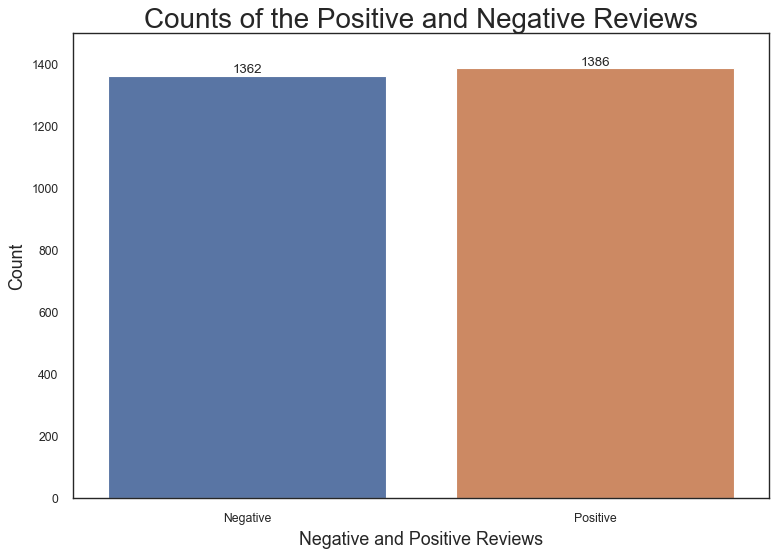

In [879]:
(unique, counts) = np.unique(data['Label'], return_counts=True)

sns.set_theme(style="white")
plt.figure(figsize=(10,7))
ax = sns.barplot(x=['Negative', 'Positive'], y=counts)
ax.bar_label(ax.containers[0])
plt.title("Counts of the Positive and Negative Reviews", fontsize=25)
plt.xlabel("Negative and Positive Reviews", fontsize=16)
plt.ylim(0, 1500)
plt.ylabel("Count", fontsize=16)
plt.show() 

With the data imported and visualized, it would be good to understand the words contained in the data set a bit more. Are there any special characters? How large is the vocabular size? The prior question is best suited for regular expressions (regex) and the latter using `CountVectorizer` from sklearn.

Regular expressions (Regex), while having a very odd looking format, has some very powerful abilities to extract the desired values from a string. Because we are searching for odd special characters, regex is the perfect tool. A way to find all special characters is to loop through each `data.Text` values in the 'Text' column and print off all the odd ones. 

The results find a series of special characters found in other non-english languages. Some of these were from reviews containing spanish or foreign names, while others are adopted english words such as 'fiancé.'

The oddest values were those with a match '\x96' as a match. These are a special character but only because the program didn't know what to do with them. Opening them in notepad shows that they are not abnormal characters but em-dashes, en-dashes, or double spaces. 

In [880]:
i = 0
while i <= len(data.Text) - 1:
    odds = re.search('[^A-Za-z0-9!"#$%&()*+,-./:;<=>?@[\\]\'^_`{|}~\t\n ]', data.Text[i])
    if odds != None:
        print(odds, i)
    i += 1

<re.Match object; span=(8, 9), match='é'> 150
<re.Match object; span=(26, 27), match='é'> 598
<re.Match object; span=(6, 7), match='ê'> 823
<re.Match object; span=(82, 83), match='é'> 915
<re.Match object; span=(40, 41), match='\x96'> 2018
<re.Match object; span=(4771, 4772), match='é'> 2019
<re.Match object; span=(13, 14), match='\x85'> 2117
<re.Match object; span=(23, 24), match='\x96'> 2121
<re.Match object; span=(81, 82), match='é'> 2226
<re.Match object; span=(163, 164), match='é'> 2271
<re.Match object; span=(62, 63), match='å'> 2297
<re.Match object; span=(28, 29), match='\x96'> 2319
<re.Match object; span=(33, 34), match='\x97'> 2359
<re.Match object; span=(115, 116), match='\x96'> 2562
<re.Match object; span=(22, 23), match='é'> 2569
<re.Match object; span=(1642, 1643), match='\x96'> 2646
<re.Match object; span=(23, 24), match='\x85'> 2715


`CountVectorizer` is a method used to convert string data into a numeric format that a computer is able to read. It does this by turning each specified subset into a vector. `CountVectorizer` takes a document and then tokenizes all the words. Tokenize means to assign each word to dictionary value with a value and a key. Doing a `len()` of the entire vocabulary list will give the count for the number of tokens in the data set.<sup>4, 5, 6</sup>

In [901]:
vectorizer = CountVectorizer()
vectorizer.fit(data.Text)
print('There are', len(vectorizer.vocabulary_), 'different words in the document.')

There are 5155 different words in the document.


The next step is to see what the sequence looks like in terms of length. The best way to do this and have the data ready for padding is using the `Tokenizer` method from `keras.preprocessing`. While the `CountVectorizer` has accomplished much of this already, it does not provide a way to sequence the texts like the `Tokenizer` method does. The `text_to_sequence` function places all the IDs into a subarray for each review. Once this is created, the length of the longest subarray can be found. This is very imporant for the padding and to use as an input for the NN. This can be found using a `len(max())` where the key for the max is the length.<sup>3</sup>

In [900]:
tokenizer = Tokenizer(num_words=6000, filters='[^A-Za-z0-9!"#$%&()*+,-./:;<=>?@[\\]\'^_`{|}~\t\n ]', lower=True)

tokenizer.fit_on_texts(data.Text)

sequenced = tokenizer.texts_to_sequences(data.Text)

longest = len(max(sequenced, key=len))
print(f"The longest review has {longest} tokens.")
vocab_size = len(tokenizer.word_index) + 1

The longest review has 1640 tokens.


With the maximum sequence length determined, the padding can be set. Padding sets all the sequence inputs to even lengths by making it the same length as the longest sequence.  The rest of the sequences have the same list length but with zeroes to fill in for the tokens not present. The zeroes can either trail or proceed the rest of the token IDs with either way working equally well and is typically a matter of preference. In this case the padded zeroes are before. An example of a padded sequence is shown below.<sup>3</sup>

In [922]:
final_padded = pad_sequences(sequenced, maxlen=1640)
padded_df = pd.DataFrame(final_padded)
pd.DataFrame(final_padded).to_csv('final_data.csv')
np.set_printoptions(threshold=sys.maxsize)
final_padded[42]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

As stated previously, the output or the value to be predicted in this model will be a binary classification. When working with classification prediction, two different activation functions are typically used. For multiple classifications, the `softmax` function is typically used; however, when the classification is binary, as is the case in this report, a `sigmoid` activation function performs better. `sigmoid` will be used in the final dense layer of the NN. More on this later.

Finally, the padded data set can be split into training, validation, and testing data sets by running two `train_test_split` methods in series. The first in the series gives a testing set and the remainder. Then the second creates the training and validating sets. The model is trained on the training set, then checked for accuracy using the validation set. Finally, when the modeling is complete, the model is checked using the testing set as a final check. 

In [945]:
X, X_test, y, y_test = train_test_split(final_padded, data.Label, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=21)

## Part III: Network Architecture

Pairing Neural Networks with NLP has become commonplace the past decade as NN has become more powerful and optimized to work with modern computing power. While support vector machines have been used in the past with NLP predictions, NNs typically performed better when tuned properly. This includes choosing the correct activation functions for each layer. The original NN used in this report is only four layers thick. 

The first layer sets up the network by allowing it to work with an embedded input using the input, output dimensions along with the input length. These were all found earlier when working with `CountVectorizer` and `Tokenizer`.<sup>3</sup>

The second layer is "a way to downsample (a way to reduce the size of) incoming feature vectors"<sup>3</sup> called `GlobalMaxPool1D` that takes "the maximum value of all features in the pool for each feature dimension."<sup>3</sup> `GlobalMaxPool1D` and flattening the data set are the two most popular methods, but `GlobalMaxPool1D` outperformed flattening by a large margin for this NN and was choosen.<sup>3</sup>

The third layer is the first Dense layer with an activation function. The activation function used for this layer was `relu` for it's ability to "not activate all the neurons at the same time"<sup>7</sup> meaning neurons that are less than 0 are set to 0 a deactivated. After a large number of runs, 200 nodes consistently provided the best accuracy score for the validation set.

The last dense layer was designed for the output. Only one node is needed as the output is only one value. As mentioned earlier, the activation function `sigmoid` was used for its binary capabilities. 

The model is then compiled with the loss function set to `binary_crossentropy`, a strong classification loss function optimized for binary classifications. The `adam` optimizer was used due to it being "computational efficient"<sup>8</sup> and it being "well suited for problems that are large in terms of data and/or parameters."<sup>8</sup> Finally, the evaluation metric is set to `binary_accuracy`. The evaluation metric determines how well the network is performing and will output a value based on that value. 

`model.fit()` tells the model what data sets to evaluate and how to do it. This is where the number of epochs are set, which data sets to use for validation, the batch size, and the callback parameter. `EarlyStopping()`, a method designed to stop the network early if the accuracy/loss is not changing is placed in the callback. The patience parameter in `EarlyStopping` is set to two meaning if two epochs are the similar, the network will stop rather than run through each epoch. 

The network parameters can be seen using `model.summary()`. This shows the number of parameters at each step, their shape, and type.

## Part IV: Model Evaluation

The fit method requires a number of epochs, but because of the callback parameter, the set 10 epochs was never reached. This is done for a few reasons. First, it is faster and more efficient. If the accuracy and loss is not changed between runs, why continue to run the network? Second, it can help prevent overfitting. While not the solution in this case, as the model seems to be overfitted (more on this below), it can help prevent overfitting by stopping the model from matching the training data exactly. 

In [996]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=dimensions, input_length=1640))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(300, input_dim=dimensions, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.summary()
early_stopping = EarlyStopping(patience=2)
model_fit = model.fit(X_train,
                    y_train.values,
                    epochs=10,
                    callbacks = [early_stopping],
                    verbose=True,
                    validation_data=(X_valid, y_valid),
                    batch_size=10)

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 1640, 4896)        21522816  
                                                                 
 global_max_pooling1d_48 (Gl  (None, 4896)             0         
 obalMaxPooling1D)                                               
                                                                 
 dense_169 (Dense)           (None, 300)               1469100   
                                                                 
 dense_170 (Dense)           (None, 1)                 301       
                                                                 
Total params: 22,992,217
Trainable params: 22,992,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
211/211 [==============================] - 102s 482ms/step - loss: 0.6591 - binary_accuracy: 0.6

In [997]:
start = "\033[1m"
end = "\033[0;0m"

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(start + "Training " + end + f"Accuracy - {accuracy:.4f}, Loss - {loss:.4f}")
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=False)
print(start + "Validation " + end + f"Accuracy - {accuracy:.4f}, Loss - {loss:.4f}")

Training Accuracy - 0.9990, Loss - 0.0091
Validation Accuracy - 0.8248, Loss - 0.4551


From the high accuracy value found on the training set compared to the validation set, it appears that the model is still overfitted. There are a few ways to prevent overfitting with a model. Early stopping, regularization, and dropouts are the most popular techniques. Early stopping does not seem to do good enough to stop the overfitting. Dropout is a simple to implement technique that requires only one line of code in between the dense layers. The concept is also quite simple: a few random nodes are deactivated &mdash; with the number of nodes determined by the dropout parameter value. This prevents the model from being too specialized to the training set and overfitting the data. Regularization is a little more difficult to implement and not used in this model, but is also commonly used to remove unnecessary features in the data and focus on what is providing the most impact to the model.<sup>9</sup>

With the final model complete, it is insightful to see what the loss and accuracy look like after each epoch. This is an excellent way of determining if the variance-bias tradeoff is sitting in the correct position. Keras makes following the progress of the neural network easy by giving access to the model's history using the `model_fit.history[]` method.

In [998]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=dimensions, input_length=1640))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(200, input_dim=dimensions, activation='relu'))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.summary()
early_stopping = EarlyStopping(patience=2)
model_fit = model.fit(X_train,
                    y_train.values,
                    epochs=10,
                    callbacks = [early_stopping],
                    verbose=True,
                    validation_data=(X_valid, y_valid),
                    batch_size=10)

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 1640, 4896)        21522816  
                                                                 
 global_max_pooling1d_49 (Gl  (None, 4896)             0         
 obalMaxPooling1D)                                               
                                                                 
 dense_171 (Dense)           (None, 200)               979400    
                                                                 
 dropout_9 (Dropout)         (None, 200)               0         
                                                                 
 dense_172 (Dense)           (None, 1)                 201       
                                                                 
Total params: 22,502,417
Trainable params: 22,502,417
Non-trainable params: 0
_________________________________________

In [999]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(start + "Training " + end + f"Accuracy - {accuracy:.4f}, Loss - {loss:.4f}")
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=False)
print(start + "Validation " + end + f"Accuracy - {accuracy:.4f}, Loss - {loss:.4f}")

Training Accuracy - 0.9981, Loss - 0.0137
Validation Accuracy - 0.8518, Loss - 0.4402


In [1000]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(start + "Testing " + end + f"Accuracy - {accuracy:.4f}, Loss - {loss:.4f}")

Testing Accuracy - 0.8036, Loss - 0.4996


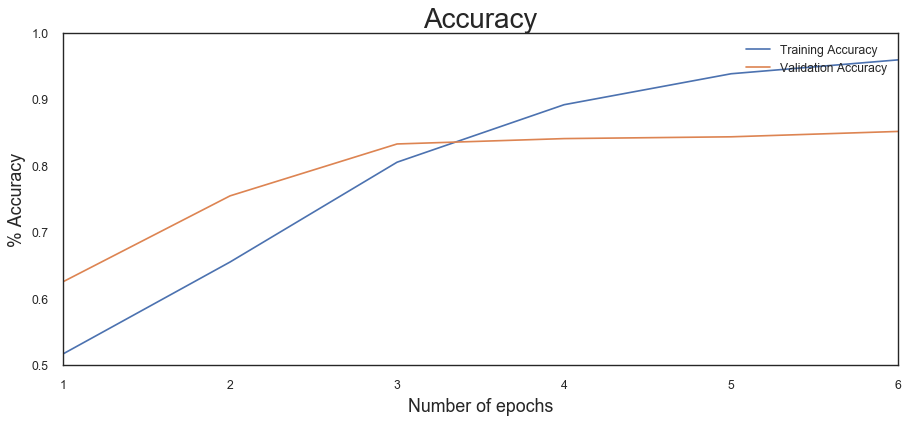

In [1029]:
x_range = range(1, 7)

plt.figure(figsize=(12, 5))
plt.plot(x_range, model_fit.history['binary_accuracy'], label='Training Accuracy')
plt.plot(x_range, model_fit.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Accuracy', fontsize=25)
plt.ylabel('% Accuracy', fontsize=16)
plt.xlabel('Number of epochs', fontsize=16)
plt.legend();

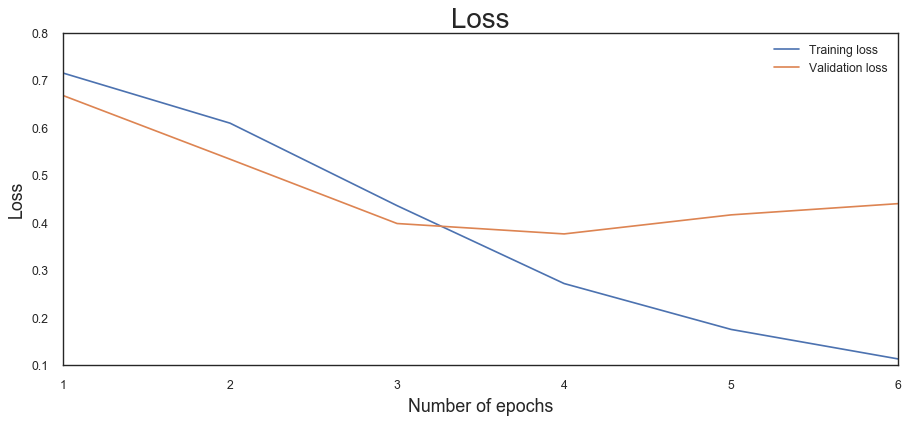

In [1028]:
plt.figure(figsize=(12, 5))
plt.plot(x, model_fit.history['loss'], label='Training loss')
plt.plot(x, model_fit.history['val_loss'], label='Validation loss')
plt.title('Loss', fontsize=25)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Number of epochs', fontsize=16)
plt.legend();

## Part V: Summary and Recommendations

With the overfitting reduced, the model is performing more accurately, especially with regards to the testing data. The network architecture has been properly tuned and optimized to give the best results given the data provided. While the validation loss started increasing slightly after 4 epochs, the accuracy was still increasing slightly. When using an early stopping callback, this seems to be a good spot to stop before the loss increases too much and the accuracy falls. 

The embedded layer and maxpooling layers take a large number of embedded words in numeric form and reduce them to the most important components. The dense layers helps form the correct weights and biases to best fit the data to the NN with the dropout layer sandwiched in to help limit overfitting. 

While the model is able to predict well, there is still room for improvement. Lemmatization was not used in this model. Ensuring that words are not repeated by breaking all words down to their roots, should reduce the vocabulary number and reduce the noise. A more thorough scanning of the vocabulary list would likely result in finding a large number of names and locations that would not be meaningful in this sentiment analysis. Stop words &mdash; meaningless, repeated words such as 'the', 'and', 'an' &mdash; were also not eliminated for this model and would yet again reduce the number of variables. 

Another method which could reduce overfitting is using regularization in the layers. This would clean up the model by reducing the number of features (L1 regularization) or all but make some features (L2 regularization). 

Overall, the trained network seemed to provide a reliable model for detecting whether a review is negative or positive. While there still remains some overfitting, the model predicts well enough to be able to take new reviews of one of our products and understand quickly the general consensus of the population's feelings towards it.

## References

1) Kotzias, D., Denil, M., De Freitas, N., & Smyth, P. (2015). 'From Group to Individual Labels using Deep Features'. *Association for Computing Machinery.* 597&ndash;606

2) Karabiber, Faith. 'Binary Classification.' *Learn Data Sci*. Accessed March 26, 2022. <<https://www.learndatasci.com/glossary/binary-classification/>>.

3) Janakiev, Nikolai. "Practical Text Classification With Python and Keras." *Real Python.* Accessed March 25, 2022. <<https://realpython.com/python-keras-text-classification/>>.

4) Jain, Pratyaksh. "Basics of CountVectorizer." *Towards Data Science.* Accessed March 22, 2022. <<https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c>>.

5) 'sklearn.feature_extraction.text.CountVectorizer.' *Scikit learn*. Accessed March 21, 2022. <<https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html>>.

6) Vasandani, Jasmine. 'I Built a Fake News Detector Using Natural Language Processing and Classification Models.' *Towards Data Science.* Accessed March 21, 2022. <<https://towardsdatascience.com/i-built-a-fake-news-detector-using-natural-language-processing-and-classification-models-da180338860e>>.

7) Dishashree26. 'Fundamentals of Deep Learning – Activation Functions and When to Use Them?' *Analytics Vidhya*. Accessed March 29, 2022. <<https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/>>.

8) Brownless, Jason. 'Gentle Introduction to the Adam Optimization Algorithm for Deep Learning.' *Machine Learning Mastery.* Accessed March 29, 2022. <<https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/>>.

9) Skalski, Piotr. 'Preventing Deep Neural Network from Overfitting.' *Towards Data Science.* Accessed March 30, 2022. <<https://towardsdatascience.com/preventing-deep-neural-network-from-overfitting-953458db800a>>.